# Setup

In [1]:
import os
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"

In [2]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
from torchvision.transforms import RandomHorizontalFlip, RandomVerticalFlip, Grayscale
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import h5py
from sklearn.metrics import confusion_matrix, accuracy_score, recall_score, precision_score, f1_score
import seaborn as sns

In [3]:
dev = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

# Data Importing

In [4]:
class Data(Dataset):
    
    def __init__(self, train=0, gray=True):
        
        # Load data
        self.train = (train == 0)
        if train == 0:
            self.x = self.load_h5_as_numpy('camelyonpatch_level_2_split_train_x.h5', 'x')
            self.y = self.load_h5_as_numpy('camelyonpatch_level_2_split_train_y.h5', 'y')[:, 0, 0, 0]
        elif train == 1:
            self.x = self.load_h5_as_numpy('camelyonpatch_level_2_split_test_x.h5', 'x')
            self.y = self.load_h5_as_numpy('camelyonpatch_level_2_split_test_y.h5', 'y')[:, 0, 0, 0]
        elif train == 2:
            self.x = self.load_h5_as_numpy('camelyonpatch_level_2_split_valid_x.h5', 'x')
            self.y = self.load_h5_as_numpy('camelyonpatch_level_2_split_valid_y.h5', 'y')[:, 0, 0, 0]
        self.gray = gray
            
        # Prepare transforms
        self.t1 = RandomHorizontalFlip(p=0.5)
        self.t2 = RandomVerticalFlip(p=0.5)
        self.g = Grayscale()
            
    def __len__(self):
        return self.x.shape[0]

    def __getitem__(self, idx):
        
        # Get images
        if torch.is_tensor(idx):
            idx = idx.tolist()
        if type(idx) is list:
            img = torch.from_numpy(self.x[idx].astype(np.float32)).permute(0, 3, 1, 2)/128 - 1
            cls = torch.from_numpy(self.y[idx])
        else:
            img = torch.from_numpy(self.x[idx].astype(np.float32)).permute(2, 0, 1)/128 - 1
            cls = self.y[idx]
            
        # Transforms
        if self.train:
            img = self.t1(self.t2(img))
        if self.gray:
            img = self.g(img)
        
        # Return
        return (img, cls)
    
    def load_h5_as_numpy(self, file_name, key):
        with h5py.File(file_name, 'r') as h5_file:
            data = h5_file[key][:]
        return data

# Models

In [5]:
# Model inspired by https://geertlitjens.nl/post/getting-started-with-camelyon/

class CustomModel(nn.Module):
    
    def __init__(self, dropout_rate=0.2, gray=False):
        
        super().__init__()
        
        first_deg = 1 if gray else 3
        
        self.conv = nn.Sequential(
            
            nn.Conv2d(first_deg, 16, 3, padding='valid'),
            nn.ReLU(),
            nn.Conv2d(16, 16, 3, padding='valid'),
            nn.ReLU(),
            nn.MaxPool2d(2),

            nn.Conv2d(16, 32, 3, padding='valid'),
            nn.ReLU(),
            nn.Conv2d(32, 32, 3, padding='valid'),
            nn.ReLU(),
            nn.MaxPool2d(2),    

            nn.Conv2d(32, 64, 3, padding='valid'),
            nn.ReLU(),
            nn.Conv2d(64, 64, 3, padding='valid'),
            nn.ReLU(),
            nn.MaxPool2d(2),
            
            nn.Flatten()
        )
        
        self.drop = nn.Dropout(dropout_rate)
        
        self.lin1 = nn.Sequential(
            nn.Linear(4096, 256),
            nn.ReLU()
        )
        
        self.lin2 = nn.Sequential(
            nn.Linear(256, 128),
            nn.ReLU()
        )
        
        self.lin3 = nn.Linear(128, 2)
        
        self.train_model = nn.Sequential(
            self.conv,
            self.drop,
            self.lin1,
            self.drop,
            self.lin2,
            self.drop,
            self.lin3
        )
        
        self.test_model = nn.Sequential(
            self.conv,
            self.lin1,
            self.lin2,
            self.lin3
        )
    
    def forward(self, x):
        if self.training:
            return self.train_model(x)
        else:
            return self.test_model(x)
        

# Training / Testing Loop

In [6]:
class Log():
    
    def __init__(self):
        self.log_text = ""

    def log(self, text):
        self.log_text += (text + "\n")
        print(text)

    def get_log(self):
        return self.log_text

In [7]:
def training(model, loss_fn, optimiser, epoch, train_name, save=False, patience=1, factor=0.4):
    
    # Setup
    logger = Log()
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimiser, mode="max", patience=patience, factor=factor, verbose=True)
    train_loss = np.zeros(epoch)
    valid_loss = np.zeros(epoch)
    
    # Main epoch loop
    for i in range(epoch):

        # Training
        model.train()
        for inputs, labels in tqdm(train_dataloader, mininterval=1):
            y_pred = model(inputs.to(dev))
            loss = loss_fn(y_pred, labels.to(dev))
            train_loss[i] += loss.item()
            optimiser.zero_grad()
            loss.backward()
            optimiser.step()

        # Validating
        model.eval()
        acc = 0
        loss = 0
        for inputs, labels in tqdm(val_dataloader, mininterval=1):
            y_pred = model(inputs.to(dev))
            acc += (torch.argmax(y_pred, 1) == labels.to(dev)).float().sum()
            valid_loss[i] += loss_fn(y_pred, labels.to(dev)).item()
        acc = 100 * float(acc) / len(val_dataloader.dataset)
        logger.log(f"Epoch {i+1}: validation accuracy {round(acc, 2)}")
        scheduler.step(acc)
        
    model.eval()
    all_labels = []
    all_predictions = []
    for inputs, labels in tqdm(val_dataloader, mininterval=1):
        y_pred = model(inputs.to(dev))
        predictions = torch.argmax(y_pred, 1)
        all_labels.extend(labels.tolist())
        all_predictions.extend(predictions.tolist())
    calculate_metrics(all_labels, all_predictions)
        
    # Normalise loss data
    train_loss = 100 * train_loss / len(train_dataloader)
    valid_loss = 100 * valid_loss / len(val_dataloader)
        
    # Create the loss plot
    epochs = np.arange(1, epoch+1)
    plt.plot(epochs, train_loss)
    plt.plot(epochs, valid_loss)
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend(['Training Loss','Validation Loss'])
    
    # Save data
    if save:
        torch.save(model.state_dict(), f'{train_name}.model')
        plt.savefig(f'{train_name}_train.png')
        with open(f'{train_name}_train.txt', "w") as text_file:
            text_file.write(logger.get_log())

In [9]:
def testing(model, test_name, save=False):
    
    # Setup
    logger = Log()
    
    # Testing
    model.eval()
    acc = 0
    for inputs, labels in tqdm(test_dataloader, mininterval=1):
        y_pred = model(inputs.to(dev))
        acc += (torch.argmax(y_pred, 1) == labels.to(dev)).float().sum()
    acc = 100 * float(acc) / len(test_dataloader.dataset)
    logger.log(f"Test accuracy {round(acc, 2)}")
    
    model.eval()
    all_labels = []
    all_predictions = []
    for inputs, labels in tqdm(test_dataloader, mininterval=1):
        y_pred = model(inputs.to(dev))
        predictions = torch.argmax(y_pred, 1)
        all_labels.extend(labels.tolist())
        all_predictions.extend(predictions.tolist())
    calculate_metrics(all_labels, all_predictions)
    
    # Saving
    if save:
        with open(f'{test_name}_test.txt', "w") as text_file:
            text_file.write(logger.get_log())

## Evaluation

In [11]:
# Calculating metrics to evaluate the model's performance
def calculate_metrics(true_labels, predicted_labels):
    # Confusion matrix
    conf_matrix = confusion_matrix(true_labels, predicted_labels)
    
    # Accuracy
    accuracy = accuracy_score(true_labels, predicted_labels)

    # Sensitivity / Recall
    sensitivity = recall_score(true_labels, predicted_labels)

    # Specificity
    TN = conf_matrix[0,0]
    FP = conf_matrix[0,1]
    specificity = TN/(TN+FP)

    # False Positives and False Negatives
    FN = conf_matrix[1,0]
    FP = conf_matrix[0,1]

    # Precision
    precision = precision_score(true_labels, predicted_labels)

    # F1-score
    f1 = f1_score(true_labels, predicted_labels)

    print("Accuracy: ", accuracy)
    print("Sensitivity/Recall: ", sensitivity)
    print("Specificity: ", specificity)
    print("False Positives: ", FP)
    print("False Negatives: ", FN)
    print("Precision: ", precision)
    print("F1-score: ", f1)

    return accuracy, sensitivity, specificity, FP, FN, precision, f1

# Running

In [12]:
# Image settings
batch_size = 32
gray = True

# Model settings
dropout_rate = 0.5

# Training settings
lr = 3
momentum = 0.95
epochs = 5

# Scheduler settings
patience = 2
factor = 0.4

# Name
name = f"{epochs}_SGD_{lr}_{momentum}_{dropout_rate}_{batch_size}_d_t{'g' if gray else ''}"

In [13]:
train_dataloader = DataLoader(Data(train=0, gray=gray), batch_size=batch_size)
test_dataloader = DataLoader(Data(train=1, gray=gray), batch_size=batch_size)
val_dataloader = DataLoader(Data(train=2, gray=gray), batch_size=batch_size)

100%|██████████| 1024/1024 [00:07<00:00, 137.61it/s]


Epoch 1: validation accuracy 76.67


100%|██████████| 1024/1024 [00:07<00:00, 143.77it/s]


Epoch 2: validation accuracy 78.47


100%|██████████| 1024/1024 [00:06<00:00, 153.15it/s]


Epoch 3: validation accuracy 79.39


100%|██████████| 1024/1024 [00:06<00:00, 156.28it/s]


Epoch 4: validation accuracy 79.36


100%|██████████| 1024/1024 [00:07<00:00, 137.37it/s]


Epoch 5: validation accuracy 79.67


100%|██████████| 1024/1024 [00:07<00:00, 139.96it/s]


Accuracy:  0.796661376953125
Sensitivity/Recall:  0.7480603579937687
Specificity:  0.8451734861881822
False Positives:  2539
False Negatives:  4124
Precision:  0.8282602813852814
F1-score:  0.7861201168426796


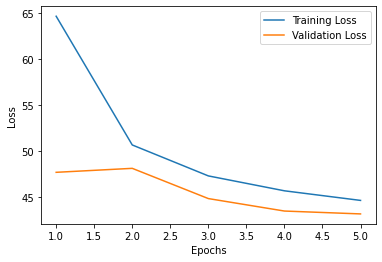

In [14]:
model = CustomModel(dropout_rate=dropout_rate, gray=gray).to(dev)
loss_fn = nn.CrossEntropyLoss()

optimiser = torch.optim.SGD(model.parameters(), lr=10**(-lr), momentum=momentum)
training(model, loss_fn, optimiser, epochs, name, save=True, patience=patience, factor=factor)

In [15]:
testing(model, name, save=True)

100%|██████████| 1024/1024 [00:07<00:00, 145.74it/s]


Test accuracy 79.62


100%|██████████| 1024/1024 [00:05<00:00, 173.60it/s]

Accuracy:  0.796234130859375
Sensitivity/Recall:  0.7601514318861818
Specificity:  0.8322860106155817
False Positives:  2749
False Negatives:  3928
Precision:  0.8191209369653902
F1-score:  0.7885352335708631
